In [1]:
import matplotlib.pyplot as plt
import librosa
import torchaudio
import numpy as np
import torch
import torchyin
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import soundfile as sf

import src.utils as utils
import src.models as models
import src.spectrograms as spec
import src.init as init

eps = 1e-5

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(
/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Creating W from single note audio files

In [2]:
single_note = "test-data/single-notes-2"

In [3]:
W, freqs, sample_rate, true_freqs = init.init_W(single_note)
# W, freqs, sample_rate = init.init_W()
W_max = spec.max_columns(W)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


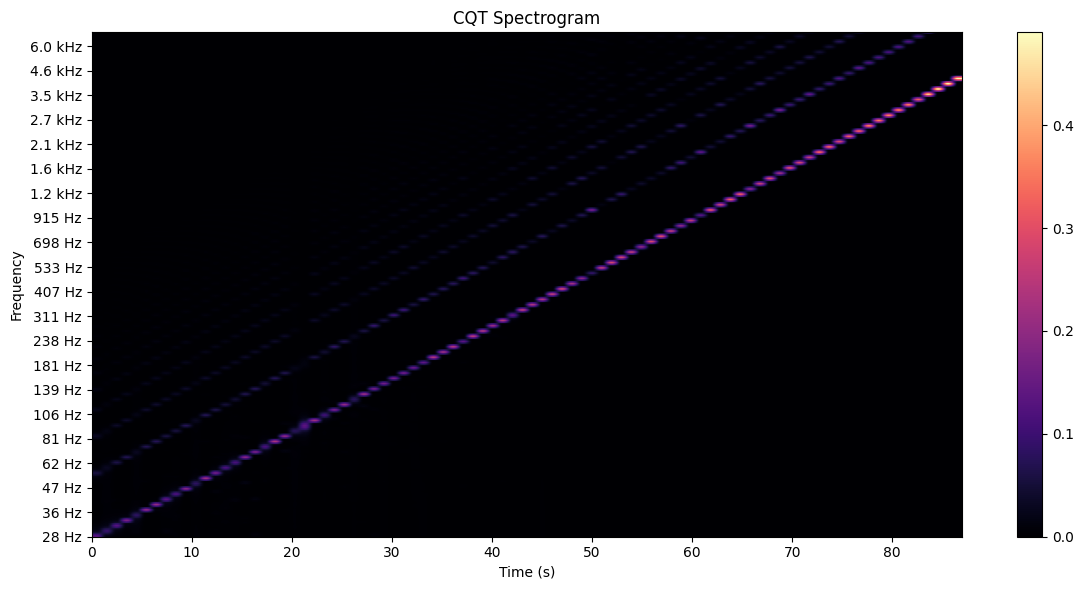

In [4]:
spec.vis_cqt_spectrogram(W, np.arange(W.shape[1]), freqs, 0, W.shape[1], add_C8=False)

### Running MU iterations on a simple example from init W

In [5]:
number = 6
waveform_test, sample_rate_test = torchaudio.load(f"dataset/audios/example-{number}.wav")
cqt_test, times_test, freq_test = spec.cqt_spec(waveform_test, sample_rate_test, 256)

# spec.vis_cqt_spectrogram(cqt_test, times_test, freq_test, 0, times_test[-1])
midi, times = spec.midi_to_pianoroll(f"dataset/midis/example-{number}.mid", waveform_test, times_test, hop_length=128)
onset, offset = utils.detect_onset_offset(midi)

In [6]:
f, t = cqt_test.shape
l = W.shape[1]
n_init_steps = 10

H = init.init_H(l, t, W, cqt_test, n_init_steps, beta=1)
# kernel = utils.gaussian_kernel(sigma=9, is_2d=True)
# H = utils.filter1d_tensor(H, kernel)

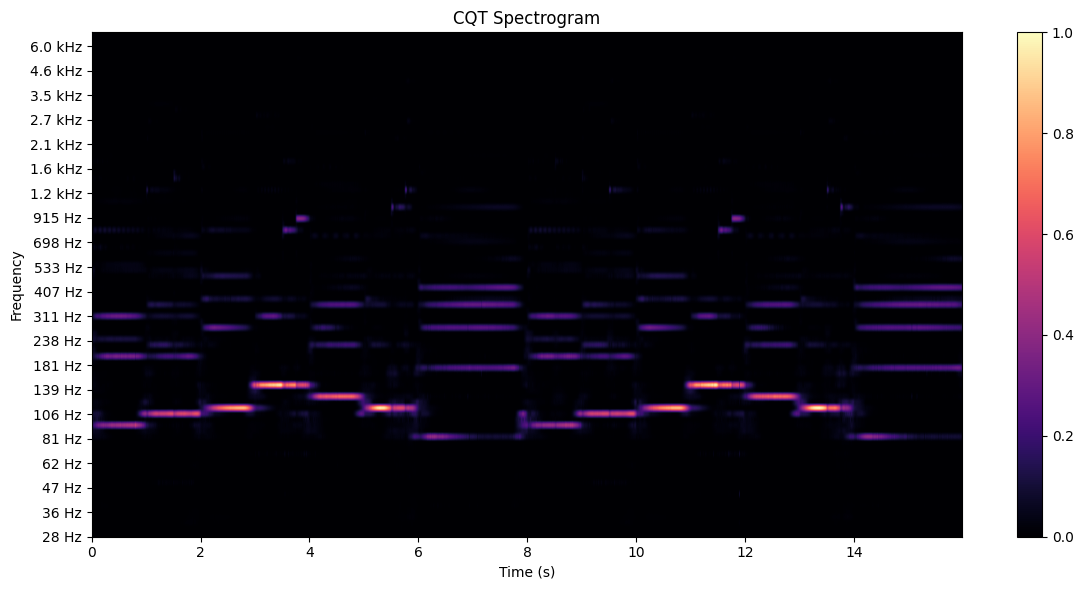

In [7]:
spec.vis_cqt_spectrogram(H, times_test, freqs, 0, times_test[-1])

#### Reconstructing the CQT from W and H:

In [8]:
M_hat = W @ H
# spec.vis_cqt_spectrogram(M_hat, times_test, freq_test, 0, times_test[-1])
# spec.vis_cqt_spectrogram(cqt_test, times_test, freq_test, 0, times_test[-1])

In [9]:
loss_function = nn.MSELoss()
loss = loss_function(M_hat, cqt_test)
diff = M_hat - cqt_test
loss

tensor(1.6219e-05)

### Retrieving frequencies and notes from W

In [10]:
frequencies_predicted, notes_predicted = init.W_to_pitch(W, true_freqs, use_max=True)
frequencies_gt, notes_gt = init.W_to_pitch(W, true_freqs, use_max=False)
# print(notes_predicted, len(notes_predicted))
# notes_new, W_new_rearranged = init.W2pitch(W_new, W, notes_gt)
# notes_new

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/Unrolled-NMF/src/init.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frequency = torch.tensor(frequency, dtype=torch.float32)


In [ ]:
# Visualize the evolution of W passing though several RALMU blocks
aw = models.Aw_cnn(hidden_channels=16)
block = models.RALMU_block(shared_aw=aw, use_ah=False)

W, freqs, sample_rate, true_freqs  = init.init_W(single_note)

waveform_test, sample_rate_test = torchaudio.load(f"dataset/audios/example-2.wav")
M, _, _ = spec.cqt_spec(waveform_test, sample_rate_test, 256)

f, t = M.shape
l = W.shape[1]
n_init_steps = 100
H = init.init_H(l, t, W, M, n_init_steps, beta=1)

# spec.vis_cqt_spectrogram(W, np.arange(W.shape[1]), freqs, 0, W.shape[1])

W_hat, H_hat = block(M, W, H)
# spec.vis_cqt_spectrogram(W_hat.detach().numpy(), np.arange(W_hat.shape[1]), freqs, 0, W_hat.shape[1])

layers = 5

for i in range(layers):
    W_hat, H_hat = block(M, W_hat, H_hat)
    spec.vis_cqt_spectrogram(W_hat.detach().numpy(), np.arange(W_hat.shape[1]), freqs, 0, W_hat.shape[1])
    

In [ ]:
# Visualize the conv layers for Aw
fig, axs = plt.subplots((3), figsize=(10,30))
params = [param for param in aw.parameters() if len(param.shape)==3]
for i, param in enumerate(params):
    if len(param.shape) == 3:
        axs[i].imshow(param[:,0,:].detach().numpy(), aspect="auto")

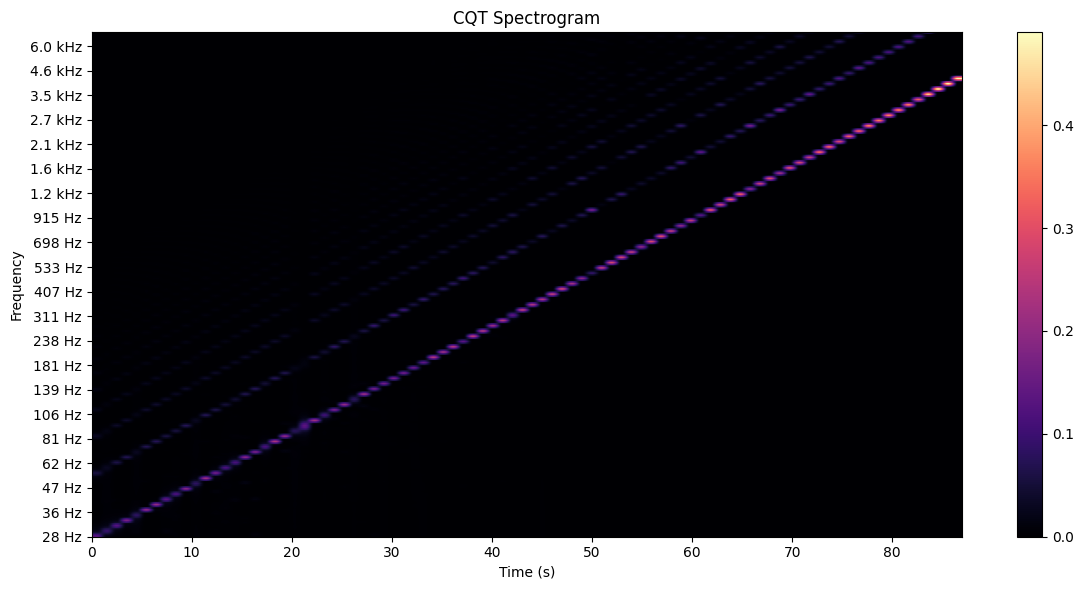

In [11]:
spec.vis_cqt_spectrogram(W, np.arange(W.shape[1]), freqs, 0, W.shape[1])

In [12]:
diff = torch.abs(notes_predicted - notes_gt)
diff.sum()
diff

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.])

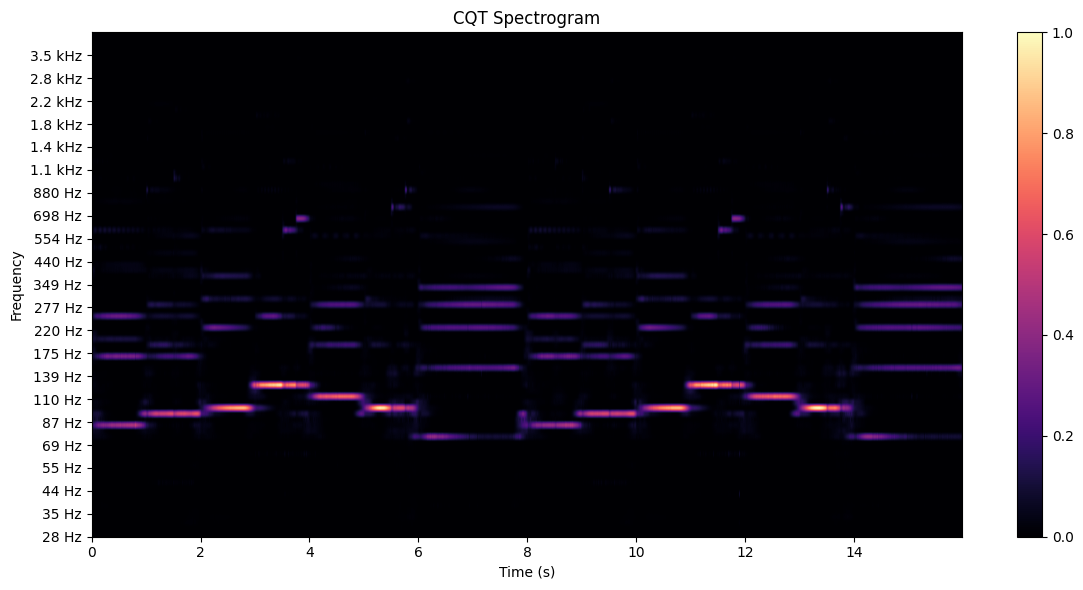

In [13]:
spec.vis_cqt_spectrogram(H, times_test, frequencies_predicted, 0, times_test[-1])

### Retrieving MIDI from W and H

In [41]:
midi_hat, active_midi_hat = init.WH_to_MIDI(W, H, notes_predicted, threshold=0.005, smoothing_window=5, adaptative=False, normalize=True)
active_midi = [i for i in range(88) if (midi[i,:]>0).any().item()]
# print(f"Detected {len(active_midi_hat)} notes, GT = {len(active_midi)}, same notes? {active_midi==active_midi_hat}")
# for i, (gt, predicted) in enumerate(zip(active_midi, active_midi_hat)):
#     if gt != predicted:
#         print(f"index {i}: {gt} ≠ {predicted}, diff = {abs(gt - predicted)}")

tensor1 = torch.tensor(active_midi)
tensor2 = torch.tensor(active_midi_hat)
unique_to_list1 = tensor1[~torch.isin(tensor1, tensor2)]
unique_to_list2 = tensor2[~torch.isin(tensor2, tensor1)]
print("Unique to gt:", ", ".join(map(str, unique_to_list1.tolist())))
print("Unique to prediction:", ", ".join(map(str, unique_to_list2.tolist())))

Unique to gt: 34, 45, 62, 65
Unique to prediction: 7, 20, 23, 29


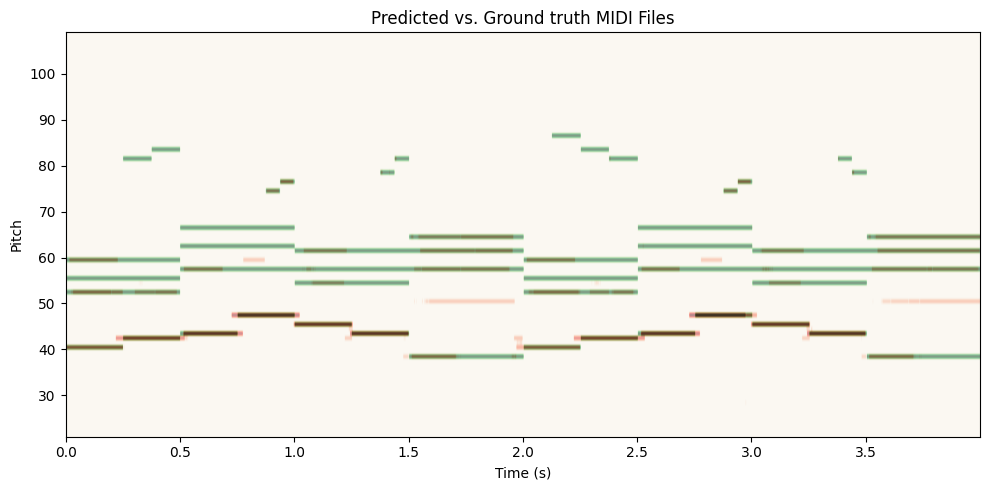

In [39]:
spec.compare_midi(midi, midi_hat, times_test, 0, 4)

In [42]:
criterion = nn.BCELoss()
loss = criterion(midi_hat[active_midi,:], midi[active_midi,:])
loss

tensor(10.6638)

### MIDI reconstruction

In [ ]:
midi_hat, active_midi = init.WH_to_MIDI(W, H, notes_predicted, threshold=0.01, smoothing_window=5, adaptative=False, normalize=True)
active_midi

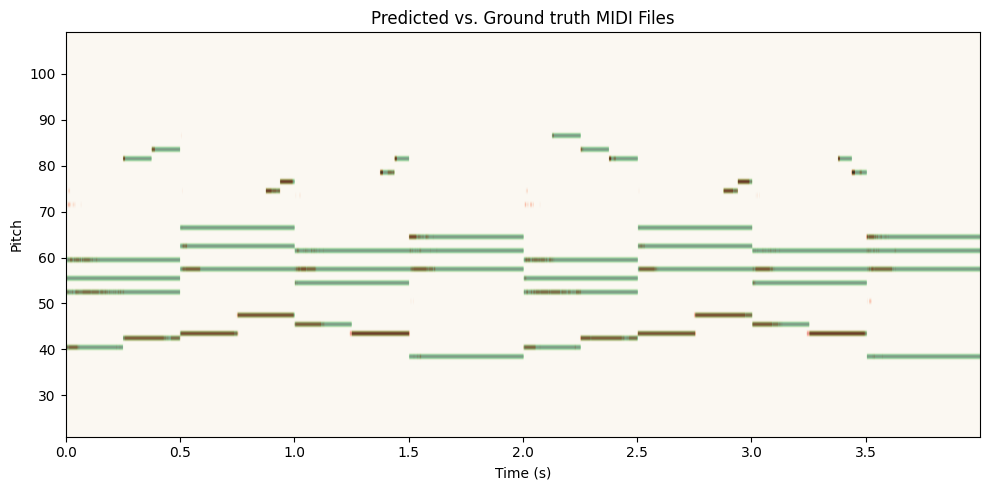

In [53]:
spec.compare_midi(midi, midi_hat, times_test, 0, 4)

### Training

Grad norm: 4.868903852184303e-05
Grad norm: 3.5203324699750738e-09
Grad norm: 0.0001249897904926911
Grad norm: 1.3848075464117926e-11
Grad norm: 6.792065687477589e-05
Grad norm: 2.337186742806807e-06
Grad norm: 2.0544215658446774e-05
Grad norm: 4.274494494893588e-05
Grad norm: 1.7082598787965253e-05
Grad norm: 3.913799810106866e-05
Grad norm: 4.2518902773736045e-05
Grad norm: 5.686339399346707e-09
Grad norm: 5.931979467277415e-05
Grad norm: 1.2771201630956686e-11
Grad norm: 0.00010167686559725553
Grad norm: 6.2191920733312145e-06
Grad norm: 7.844151696190238e-06
Grad norm: 2.9146012821001932e-05
Grad norm: 1.9618986698333174e-05
Grad norm: 6.72232563374564e-05
Grad norm: 9.971205145120621e-05
Grad norm: 5.324406693318906e-09
Grad norm: 0.0001571409375173971
Grad norm: 3.763592215655365e-11
Grad norm: 0.0003503216430544853
Grad norm: 2.6071114916703664e-05
Grad norm: 2.26036281674169e-05
Grad norm: 6.187769758980721e-05
Grad norm: 4.69647093268577e-05
Grad norm: 0.00012135387805756181
G

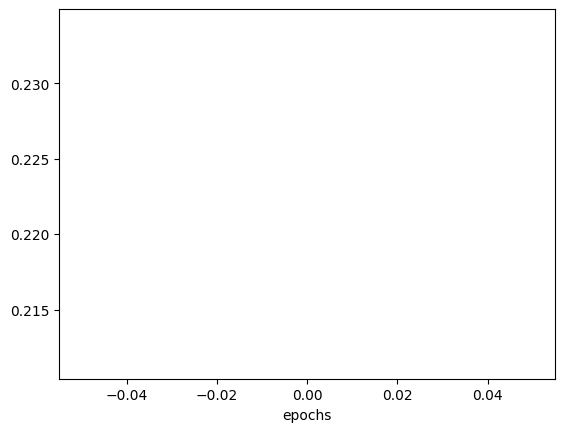

In [ ]:
model = models.RALMU(l, eps, beta=1, W_path=single_note, n_iter=5, shared=True)
model = models.RALMU(l, eps, beta=1, n_iter=5, W_path=single_note, n_init_steps=10, hidden=16, use_ah=False, shared=True) 
# model = models.RALMU(l, eps, beta=1, n_iter=5, n_init_steps=10, hidden=16, use_ah=False, shared=True) 
utils.model_infos(model, names=False)
device  = torch.device('cpu')
model.to(device=device)
dataset = utils.MaestroNMFDataset("dataset/audios", "dataset/midis")
loader  = DataLoader(dataset, batch_size=1, shuffle=False)

train1 = False
n_epochs1 = 10
optimizer1 = torch.optim.AdamW(model.parameters(), lr=1e-3)

train2 = True
n_epochs2 = 10
criterion = nn.MSELoss()
optimizer2 = torch.optim.AdamW(model.parameters(), lr=1e-2)
optimizer2.zero_grad()

lambda_l    = torch.ones(model.n_iter)#torch.arange(0, 1, 1/model.n_iter)
# decay of the blurring across layers
start_value = 7
end_value   = 1
base        = (end_value / start_value) ** (1 / (model.n_iter - 1))
sigma       = torch.tensor([start_value * (base ** i) for i in range(model.n_iter)])

if train1:
    utils.warmup_train(model, n_epochs1, loader, optimizer1, device)

if train2:
    losses   = []
    accumulation_steps = 3
    optimizer2.zero_grad()
    for j in range(n_epochs2):
        inter_loss = []
        for M, midi_batch in loader:
            model.init_H(M.squeeze(0))
            M = M.to(device)
            # spec.vis_cqt_spectrogram(model.W0, np.arange(model.W0.shape[1]), model.freqs, 0, model.W0.shape[1])
            # batch, f, t = M.shape
            # l = model.W0.shape[1]

            # H = init.init_H(l, t, W, M[0], model.n_init_steps, model.beta)
            # spec.vis_cqt_spectrogram(H, np.arange(H.shape[1]), model.freqs, 0, H.shape[1])
            midi_batch = midi_batch.to(device)

            W_layers, H_layers, M_hats = model(M)
            total_loss = 0
            
            for layer in range(model.n_iter):
                W_hat = W_layers[layer]
                H_hat = H_layers[layer]
                M_hat = M_hats[layer]

                frequencies_predicted, notes_predicted, W_new, H = init.W_to_pitch(W_hat, model.freqs, H=H_hat, use_max=True)
                # spec.vis_cqt_spectrogram(W_hat.detach().numpy(), np.arange(W_hat.shape[1]), frequencies_predicted, 0,W_hat.shape[1])
                # print(len(notes_predicted), notes_predicted.max())
                if notes_predicted.max() > 87:
                    spec.vis_cqt_spectrogram(W_hat.detach().numpy(), np.arange(W_hat.shape[1]), frequencies_predicted, 0,W_hat.shape[1])
                midi_hat, active_midi_hat = init.WH_to_MIDI(W_new, H_hat, notes_predicted, threshold=0.005, smoothing_window=5, adaptative=False, normalize=True)

                midi_batch = midi_batch.squeeze(0)
                active_midi = [i for i in range(88) if (midi_batch[i,:]>0).any().item()]
                
                # Blur the MIDIs before computing the MSE loss
                kernel = utils.gaussian_kernel(sigma=sigma[layer], is_2d=True)
                midi_batch_f = utils.filter1d_tensor(midi_batch, kernel)
                midi_hat_f = utils.filter1d_tensor(midi_hat, kernel)

                loss = criterion(midi_hat_f[active_midi,:], midi_batch_f[active_midi,:])
                total_loss += lambda_l[layer] * loss
                inter_loss.append(total_loss.detach().numpy())

            total_loss.backward()
            
            for name, param in model.named_parameters():
                if param.grad.norm().item() > 1:
                    print(f"Grad norm: {param.grad.norm().item()}")
                else:
                    print(f"Grad is None for {name}")
            if (j + 1) % accumulation_steps == 0:
                optimizer2.step()
                optimizer2.zero_grad()
            print("====== New audio file ======")
    losses.append(np.mean(inter_loss)) 
    print(f"------------ Epoch {j}, loss = {np.mean(inter_loss)} ------------") 

    plt.plot(losses, label='Transcription MSE loss over epochs')
    plt.xlabel('epochs')
    plt.show()

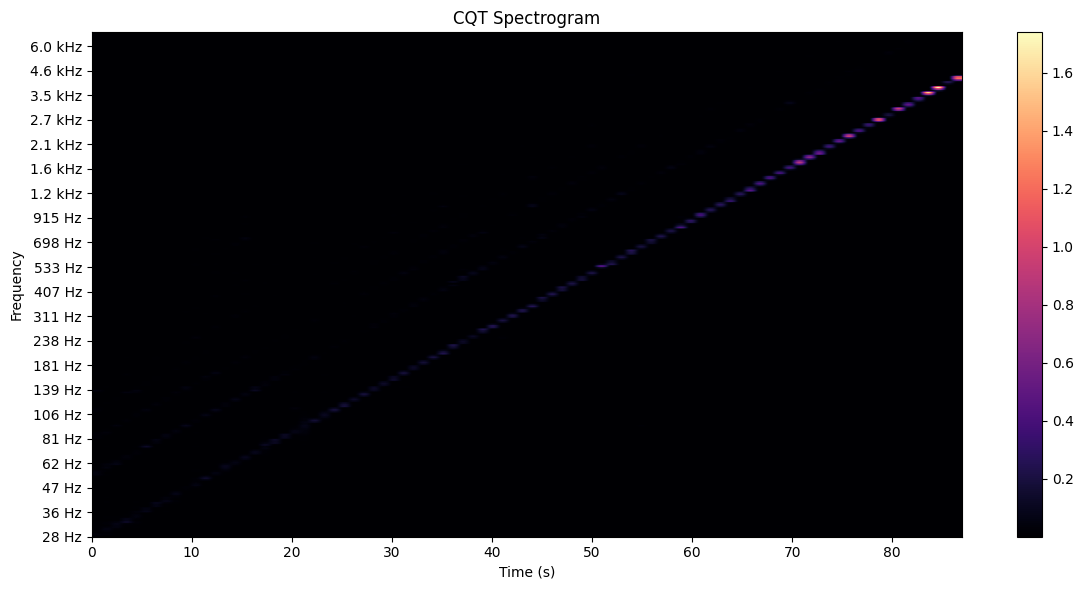

In [ ]:
# W, freqs, sample_rate  = init.init_W(single_note)

waveform_test, sample_rate_test = torchaudio.load(f"dataset/audios/example-2.wav")
M, _, _ = spec.cqt_spec(waveform_test, sample_rate_test, 256)

f, t = M.shape
l = W.shape[1]
n_init_steps = 100
H = init.init_H(l, t, W, M, n_init_steps, beta=1)

# spec.vis_cqt_spectrogram(W, np.arange(W.shape[1]), freqs, 0, W.shape[1])
model.init_H(M.squeeze(0))
W_layers, H_layers, M_hats = model(M)
spec.vis_cqt_spectrogram(W_layers[-1].detach().numpy(), np.arange(W_layers[-1].shape[1]), freqs, 0, W_layers[-1].shape[1])    

In [8]:
notes = torch.empty(W_hat.shape[1])
pitches = torch.empty(W_hat.shape[1])
ids = torch.empty(W_hat.shape[1])

for i in range(W_hat.shape[1]):
    _, max_id = torch.max(W_hat[:,i], dim=0)
    ids[i] = max_id
    # print(max_id)
    freqs = librosa.cqt_frequencies(W_hat.shape[0], fmin=librosa.note_to_hz('A0'), bins_per_octave=36)
    freq = freqs[max_id] # Use freq with max amplitude in the CQT
    if freq >= 27.5 and freq <= 4186:
        pitches[i] = freq
    # print(pitch)
    notes[i] = init.frequency_to_note(pitches[i], thresh=0.4) - 21
print(ids.max(), pitches.max())

tensor(281.) tensor(3875.7200)


/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/Unrolled-NMF/src/init.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frequency = torch.tensor(frequency, dtype=torch.float32)


In [10]:
W = model.forward(cqt_test)
spec.vis_cqt_spectrogram(W.detach().numpy(), np.arange(W.shape[1]), freqs, 0, W.shape[1])

RuntimeError: The size of tensor a (1379) must match the size of tensor b (2757) at non-singleton dimension 2

In [16]:
loss = utils.loss_midi(midi_hat, midi)
loss

tensor(2078.7217)

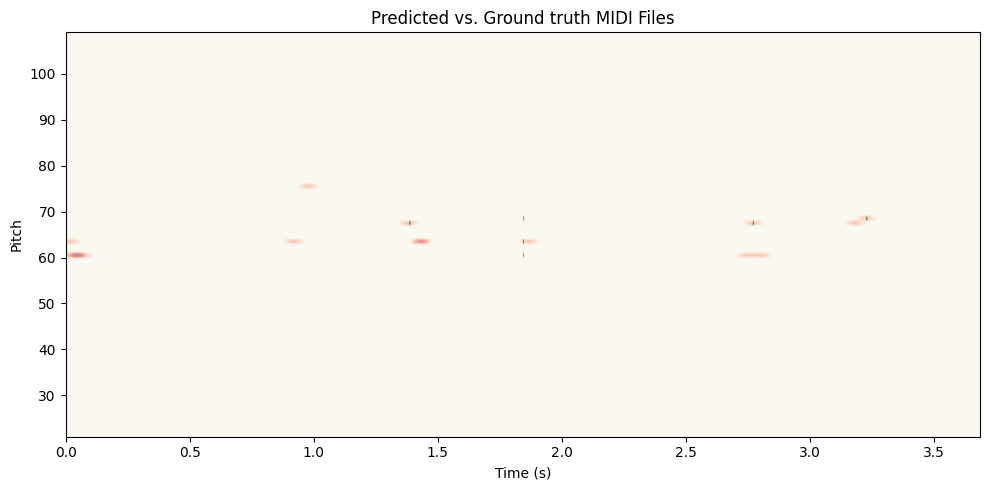

In [12]:
onset_hat, offset_hat = utils.detect_onset_offset(midi_hat, filter=True)
spec.compare_midi(onset,onset_hat, times_test, 0, times_test[-1])

In [ ]:
f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=sr, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0, sr=sr)

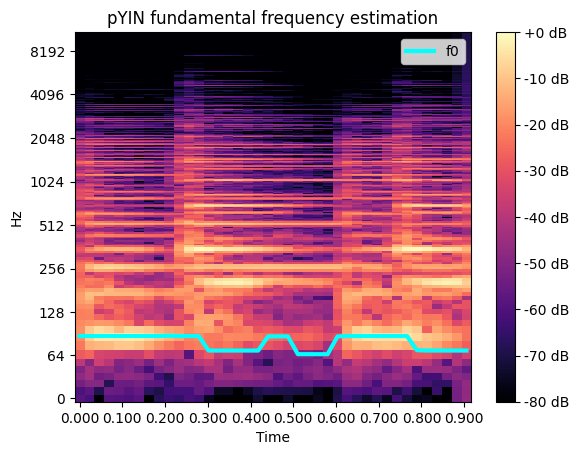

In [ ]:
import matplotlib.pyplot as plt
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')